# AWS SageMaker for customer Loyalty prediction (XGBoost)

## Importing packages

In [1]:
import sagemaker
import boto3
import pandas as pd
import numpy as np
from sagemaker.amazon.amazon_estimator import get_image_uri 
from sagemaker.session import s3_input, Session
from sklearn.utils import shuffle

## Creating S3 bucket

In [2]:
bucket_name = 'customerloyalty12'
my_region = boto3.session.Session().region_name # set the region of the instance
print(my_region)

us-east-1


In [3]:

s3 = boto3.resource('s3')
try:
    if  my_region == 'us-east-1':
        s3.create_bucket(Bucket=bucket_name)
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)

S3 bucket created successfully


In [4]:
# set an output path where the trained model will be saved
prefix = 'xgboost-as-a-built-in-algo'
output_path ='s3://{}/{}/output'.format(bucket_name, prefix)
print(output_path)

s3://customerloyalty12/xgboost-as-a-built-in-algo/output


## Importing dataset

In [5]:
import pickle
try:
    model_data = pickle.load(open('./abc_reg_modelling.p','rb'))
    print('Success: Data loaded into dataframe.')
except Exception as e:
    print('Data load error: ',e)

Success: Data loaded into dataframe.


## EDA

In [6]:
model_data.head()

,customer_id,distance_from_store,gender,credit_score,customer_loyalty_score,toatl_sales_cost,num_items,transactions_id,product_area_id,average_basket_value
0,74,3.38,F,0.59,0.263,2563.71,297,44,5,58.266136
1,524,4.76,F,0.52,0.298,2996.02,357,49,5,61.143265
2,607,4.45,F,0.49,0.337,2853.82,350,49,5,58.241224
3,343,0.91,M,0.54,0.873,2388.31,272,54,5,44.227963
4,322,3.02,F,0.63,0.350,2401.64,278,50,5,48.032800


In [7]:
model_data.columns

Index(['customer_id', 'distance_from_store', 'gender', 'credit_score',
       'customer_loyalty_score', 'toatl_sales_cost', 'num_items',
       'transactions_id', 'product_area_id', 'average_basket_value'],
      dtype='object')

In [8]:
## drop unneccessary columns
model_data= model_data.drop(["customer_id"], axis=1)

In [9]:
### shuffle the data
model_data = shuffle(model_data, random_state=42)

In [10]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 455 to 219
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   distance_from_store     398 non-null    float64
 1   gender                  397 non-null    object 
 2   credit_score            398 non-null    float64
 3   customer_loyalty_score  400 non-null    float64
 4   toatl_sales_cost        400 non-null    float64
 5   num_items               400 non-null    int64  
 6   transactions_id         400 non-null    int64  
 7   product_area_id         400 non-null    int64  
 8   average_basket_value    400 non-null    float64
dtypes: float64(5), int64(3), object(1)
memory usage: 31.2+ KB


In [11]:
model_data['gender'].value_counts()

F    226
M    171
Name: gender, dtype: int64

In [12]:
display(model_data.describe())


,distance_from_store,credit_score,customer_loyalty_score,toatl_sales_cost,num_items,transactions_id,product_area_id,average_basket_value
count,398.000000,398.000000,400.000000,400.000000,400.00000,400.000000,400.000000,400.000000
mean,2.032261,0.596156,0.507413,1848.377300,278.19000,44.920000,4.315000,36.869348
std,2.561213,0.101267,0.293870,1759.946742,213.02077,21.155199,0.722551,19.353272
min,0.000000,0.260000,0.002000,45.950000,10.00000,4.000000,2.000000,9.342000
25%,0.712500,0.530000,0.262000,942.522500,201.00000,41.000000,4.000000,22.464754
50%,1.655000,0.590000,0.508500,1471.490000,259.00000,50.000000,4.000000,30.365417
75%,2.917500,0.660000,0.770500,2116.720000,319.25000,53.000000,5.000000,47.300978
max,44.370000,0.880000,1.000000,9878.760000,1187.00000,109.000000,5.000000,102.335417


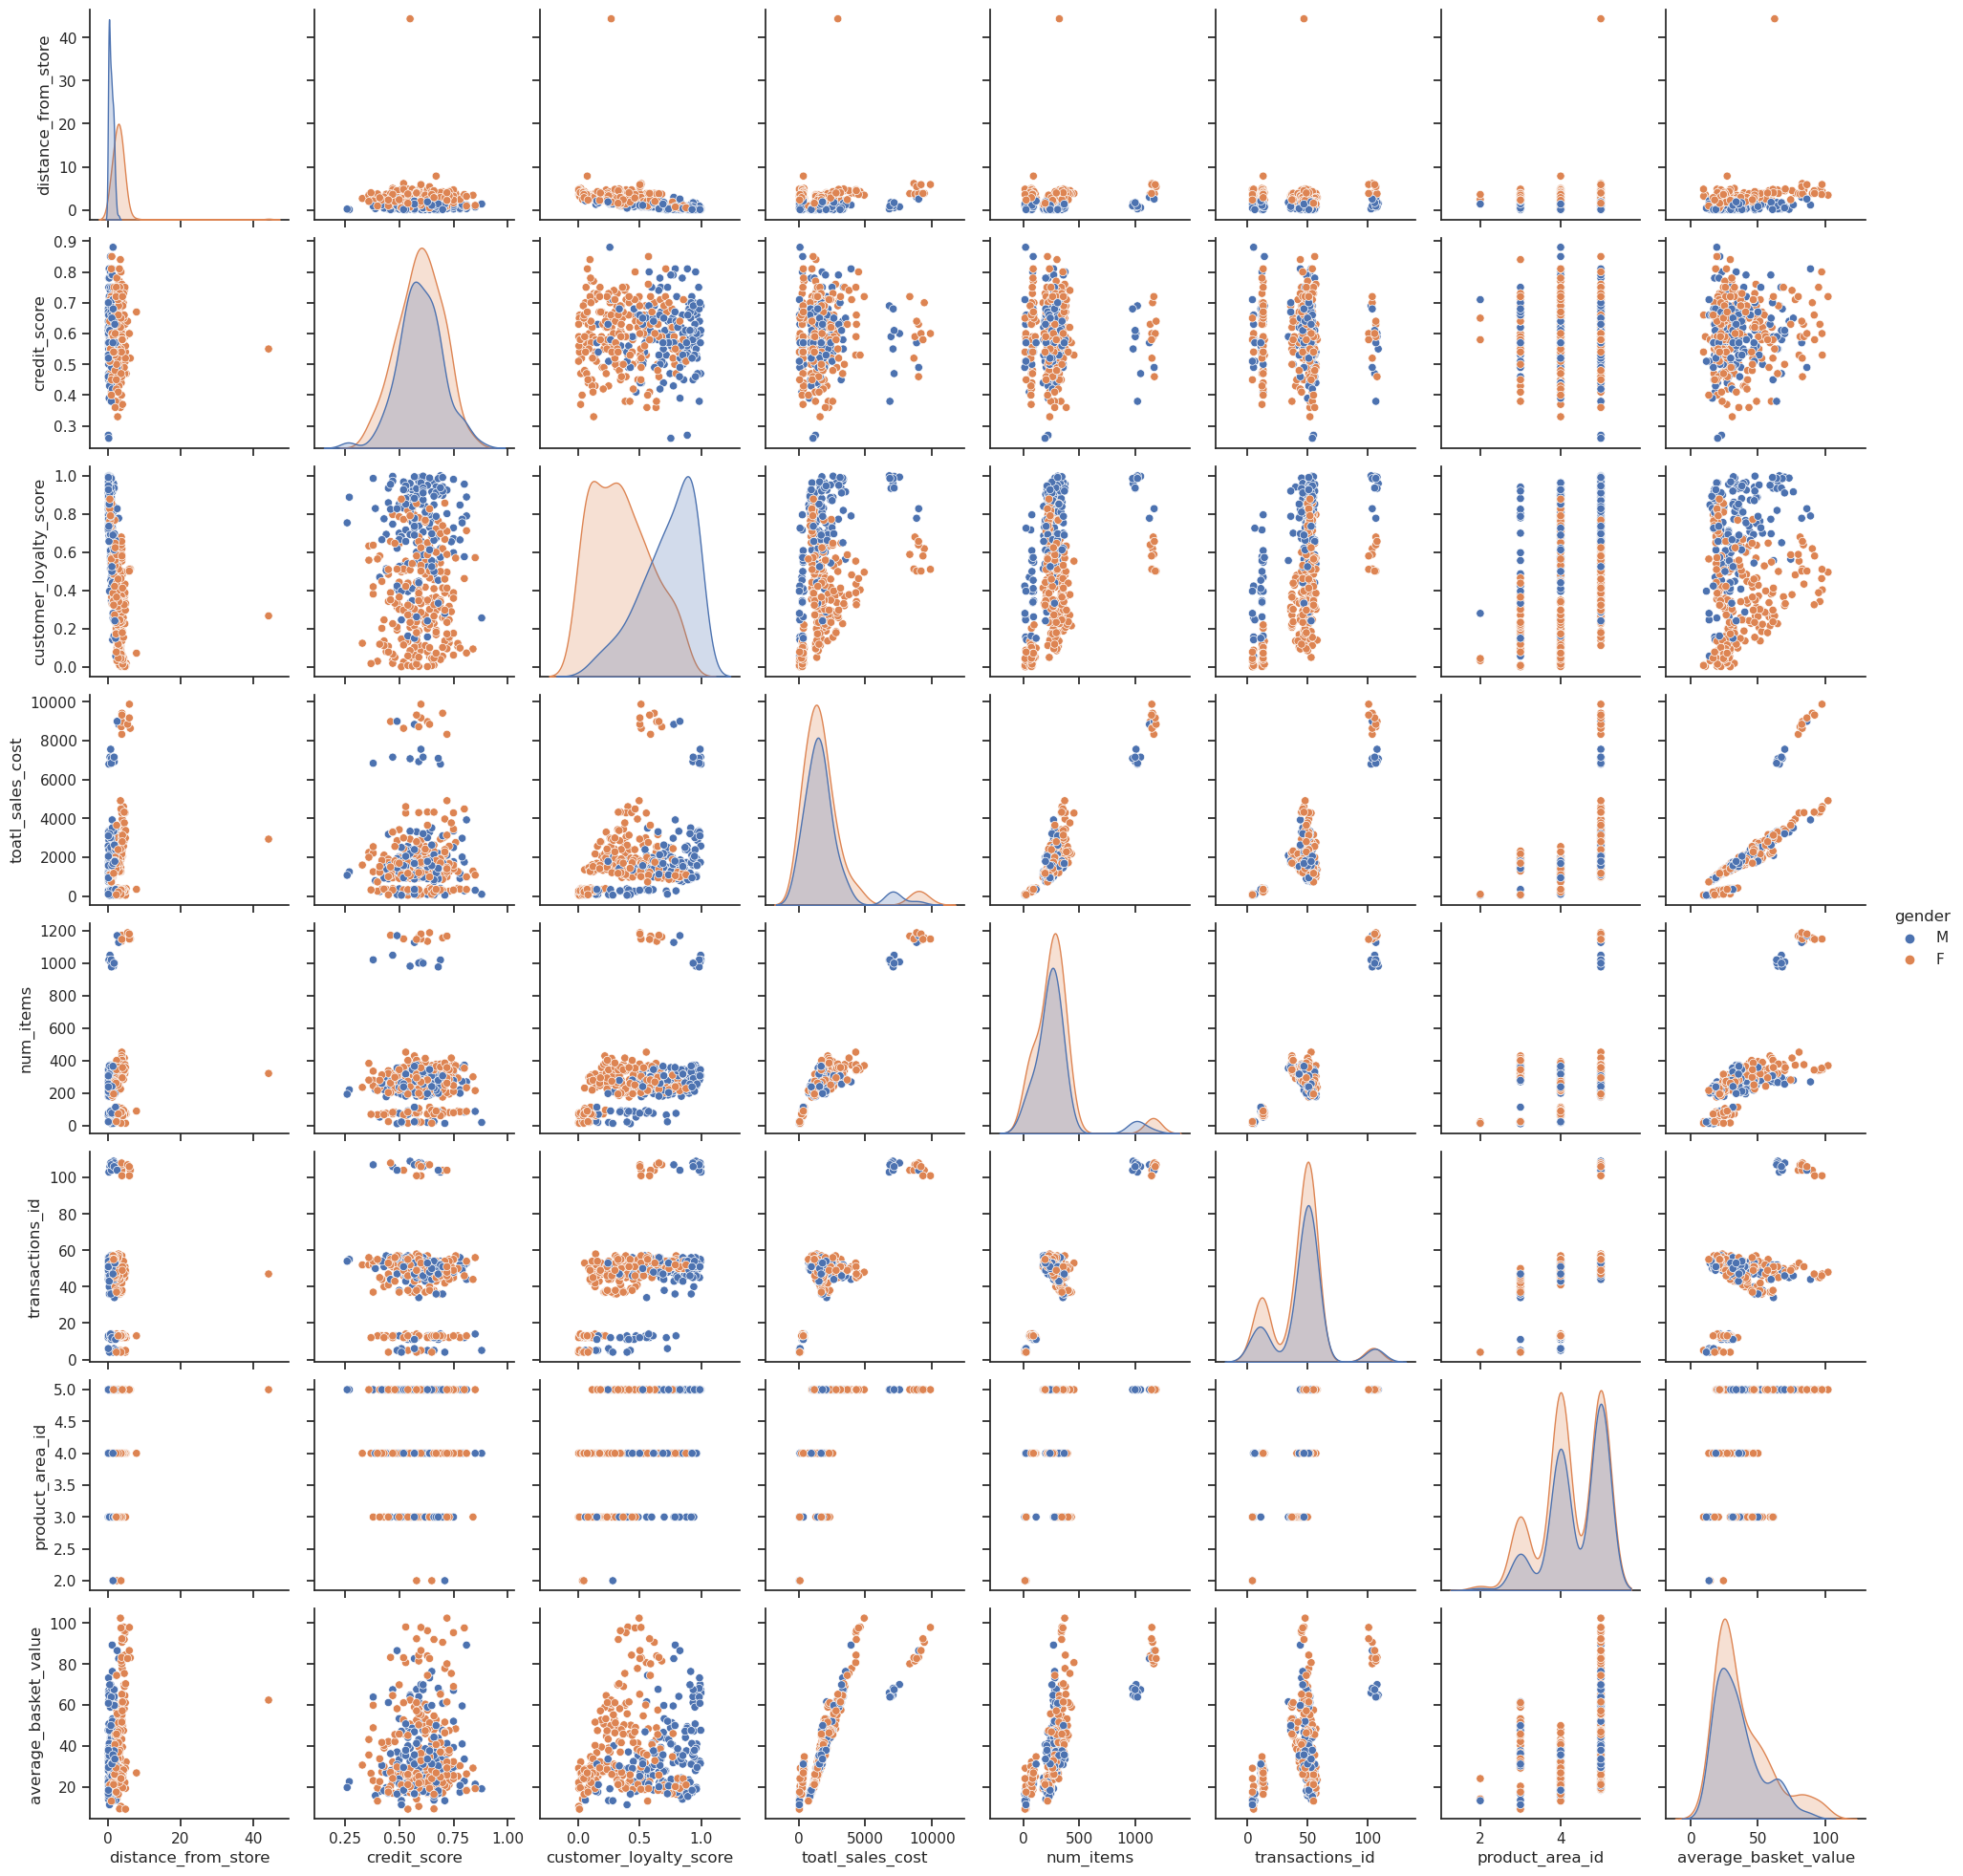

In [13]:
import seaborn as sns
sns.set_theme(style="ticks")
sns.pairplot(model_data, hue = 'gender')


#### notes: distance from store, total_sales_cost --> max values --> outlier


In [14]:
model_data.isna().sum()
model_data.dropna(how="any", inplace =True)

In [15]:
model_data.isna().sum()

distance_from_store       0
gender                    0
credit_score              0
customer_loyalty_score    0
toatl_sales_cost          0
num_items                 0
transactions_id           0
product_area_id           0
average_basket_value      0
dtype: int64

In [16]:
## Outliers detection
outlier_column=["distance_from_store","toatl_sales_cost",
               "num_items", "credit_score", "customer_loyalty_score", "average_basket_value" ]
for column in outlier_column:
    
    lower_qrt=model_data[column].quantile(0.25)
    upper_qrt=model_data[column].quantile(0.75)  
    inetrqrt_range = upper_qrt - lower_qrt
    Lower_boundary = lower_qrt - (inetrqrt_range* 2)
    Upper_boundary = upper_qrt + (inetrqrt_range* 2)
    outliers = model_data[(model_data[column] < Lower_boundary) | (model_data[column] > Upper_boundary)].index
    
    print(f"there were {len(outliers)} outliers detecetd")
    
    model_data.drop(outliers, inplace=True)

there were 2 outliers detecetd
there were 23 outliers detecetd
there were 0 outliers detecetd
there were 1 outliers detecetd
there were 0 outliers detecetd
there were 5 outliers detecetd


In [17]:
model_data = pd.get_dummies(model_data)


In [18]:
model_data.head()

,distance_from_store,credit_score,customer_loyalty_score,toatl_sales_cost,num_items,transactions_id,product_area_id,average_basket_value,gender_F,gender_M
455,0.28,0.81,0.889,990.65,243,53,4,18.691509,0,1
621,2.58,0.58,0.162,333.26,70,13,4,25.635385,1,0
64,0.80,0.80,0.956,1753.96,371,52,5,33.730000,0,1
456,0.16,0.56,0.926,929.57,225,51,4,18.226863,0,1
196,3.27,0.67,0.297,1904.55,376,36,3,52.904167,1,0


## Splitting the dataset into train, validation and test

In [19]:
train_data, validation_data, test_data = np.split(
    model_data.sample(frac=1, random_state=1729),
    [int(0.7 * len(model_data)), int(0.9 * len(model_data))],
)

## Saving Train And Test Into Buckets

In [20]:

## We start with Train Data
import os
pd.concat([train_data['customer_loyalty_score'], train_data.drop(['customer_loyalty_score', 'gender_F'], 
                                                axis=1)], 
                                                axis=1).to_csv('train.csv', index=False, header=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
s3_input_train = sagemaker.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')
     

In [21]:
# Test Data Into Buckets
pd.concat([test_data['customer_loyalty_score'], test_data.drop(['customer_loyalty_score', 'gender_F'], axis=1)], axis=1).to_csv('test.csv', index=False, header=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')
s3_input_test = sagemaker.TrainingInput(s3_data='s3://{}/{}/test'.format(bucket_name, prefix), content_type='csv')

In [22]:
## Validation data into bucket

pd.concat([validation_data['customer_loyalty_score'], validation_data.drop(['customer_loyalty_score', 'gender_F'], axis=1)], axis=1).to_csv('valid.csv', index=False, header=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'valid/valid.csv')).upload_file('valid.csv')
s3_input_valid = sagemaker.TrainingInput(s3_data='s3://{}/{}/valid'.format(bucket_name, prefix), content_type='csv')

## Building the XGBoost model

In [23]:
# this line automatically looks for the XGBoost image URI and builds an XGBoost container.

from sagemaker.amazon.amazon_estimator import image_uris
XGBOOST_IMAGE = image_uris.retrieve(region=boto3.Session().region_name, framework='xgboost', version='1.0-1')

In [24]:

# initialize hyperparameters
hyperparameters = {
        "max_depth":"5",
        "eta":"0.2",
        "gamma":"4",
        "min_child_weight":"6",
        "subsample":"0.7",
        "objective":"reg:linear",
        "num_round":50
        }
     

In [25]:
# construct a SageMaker estimator that calls the xgboost-container
estimator = sagemaker.estimator.Estimator(image_uri=XGBOOST_IMAGE, 
                                          hyperparameters=hyperparameters,
                                          role=sagemaker.get_execution_role(),
                                          instance_count=1, 
                                          instance_type='ml.m5.2xlarge', 
                                          volume_size=5, # 5 GB 
                                          output_path=output_path,
                                          use_spot_instances=True,
                                          max_run=300,
                                          max_wait=600)

In [26]:
estimator.fit({'train': s3_input_train, 'validation': s3_input_valid})

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-03-14-02-21-45-004


2023-03-14 02:21:45 Starting - Starting the training job...
2023-03-14 02:22:04 Starting - Preparing the instances for training......
2023-03-14 02:22:56 Downloading - Downloading input data...
2023-03-14 02:23:37 Training - Training image download completed. Training in progress....
2023-03-14 02:24:08 Uploading - Uploading generated training model[2023-03-14 02:24:01.381 ip-10-0-171-19.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:linear to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delim

## Deployment

In [27]:

xgb_predictor = estimator.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-03-14-02-24-59-014
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2023-03-14-02-24-59-014
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2023-03-14-02-24-59-014


--------!

## Predictions

In [30]:
from sagemaker.predictor import csv_serializer
test_data_array = test_data.drop(['customer_loyalty_score', 'gender_F'], axis=1).values#load the data into an array
xgb_predictor.serializer = csv_serializer # set the serializer type
predictions = xgb_predictor.predict(test_data_array).decode('utf-8') # predict!
predictions_array = np.fromstring(predictions[1:], sep=',') # and turn the prediction into an array
print(predictions_array.shape)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


(37,)


In [31]:
predictions_array

array([0.6204468 , 0.39781809, 0.39781809, 0.39781809, 0.6204468 ,
       0.6204468 , 0.39781809, 0.55264103, 0.39781809, 0.55264103,
       0.6204468 , 0.55264103, 0.39781809, 0.6204468 , 0.6204468 ,
       0.6204468 , 0.55264103, 0.39781809, 0.39781809, 0.6204468 ,
       0.6204468 , 0.55264103, 0.55264103, 0.39781809, 0.39781809,
       0.6204468 , 0.55264103, 0.55264103, 0.39781809, 0.6204468 ,
       0.39781809, 0.6204468 , 0.39781809, 0.39781809, 0.6204468 ,
       0.39781809, 0.39781809])

In [39]:
from sklearn import metrics 
y_test = np.array(test_data['customer_loyalty_score'])
np.sqrt(metrics.mean_squared_error(y_test, predictions_array))

0.21383720563726671

In [42]:
xgb_predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: sagemaker-xgboost-2023-03-14-02-24-59-014
INFO:sagemaker:Deleting endpoint with name: sagemaker-xgboost-2023-03-14-02-24-59-014
